# Pet Insurance Profitability Analysis: A Ratemaking and Reserving Study

## 1. Business Problem
A hypothetical insurer, "Pawtect Insurance," wants to launch a new pet insurance product. The company needs to establish a profitable pricing structure and estimate the required reserves for future claims. This project will develop a comprehensive actuarial analysis to address these needs.

## 2. Project Setup and Data Generation
First, we'll import the necessary libraries and generate a synthetic dataset of 10,000 pet insurance policies. This data will serve as the basis for our analysis.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Generation ---
np.random.seed(42)
num_policies = 10000

data = {
    'policy_id': range(1, num_policies + 1),
    'pet_age': np.random.randint(1, 15, size=num_policies),
    'pet_breed': np.random.choice(['Labrador', 'Poodle', 'Mixed', 'Bulldog', 'Beagle'], size=num_policies),
    'location': np.random.choice(['Urban', 'Rural', 'Suburban'], size=num_policies),
    'coverage_level': np.random.choice(['Basic', 'Standard', 'Premium'], size=num_policies),
    'policy_year': np.random.randint(2020, 2024, size=num_policies)
}

df = pd.DataFrame(data)

def generate_claims(row):
    base_freq = 0.1
    base_sev = 500
    age_factor = 1 + (row['pet_age'] * 0.05)
    breed_factor = {'Labrador': 1.2, 'Poodle': 0.9, 'Mixed': 1.0, 'Bulldog': 1.5, 'Beagle': 0.8}.get(row['pet_breed'], 1)
    location_factor = {'Urban': 1.3, 'Rural': 0.8, 'Suburban': 1.1}.get(row['location'], 1)
    claim_freq = base_freq * age_factor * breed_factor * location_factor
    claim_sev = base_sev * age_factor * breed_factor * location_factor
    num_claims = np.random.poisson(claim_freq)
    claims_incurred = sum(np.random.gamma(2, scale=claim_sev/2, size=num_claims))
    return claims_incurred

df['claims_incurred'] = df.apply(generate_claims, axis=1)
df['annual_premium'] = 200 + (df['pet_age'] * 20) + df['claims_incurred'].apply(lambda x: max(0, x * np.random.uniform(0.3, 0.6)))
df['claim_status'] = df['claims_incurred'].apply(lambda x: 'Paid' if x > 0 and np.random.rand() > 0.3 else 'Outstanding')

print("--- Synthetic Data Generated ---")
df.head()

--- Synthetic Data Generated ---


,policy_id,pet_age,pet_breed,location,coverage_level,policy_year,claims_incurred,annual_premium,claim_status
0,1,7,Labrador,Urban,Standard,2020,0.0,340.0,Outstanding
1,2,4,Poodle,Rural,Standard,2023,0.0,280.0,Outstanding
2,3,13,Poodle,Suburban,Premium,2020,0.0,460.0,Outstanding
3,4,11,Mixed,Urban,Premium,2022,0.0,420.0,Outstanding
4,5,8,Mixed,Rural,Basic,2020,0.0,360.0,Outstanding


## 3. Ratemaking Analysis
In this section, we'll perform an exploratory data analysis (EDA) to understand the key drivers of claims. We will then build a Generalized Linear Model (GLM) to create a risk-based pricing structure.

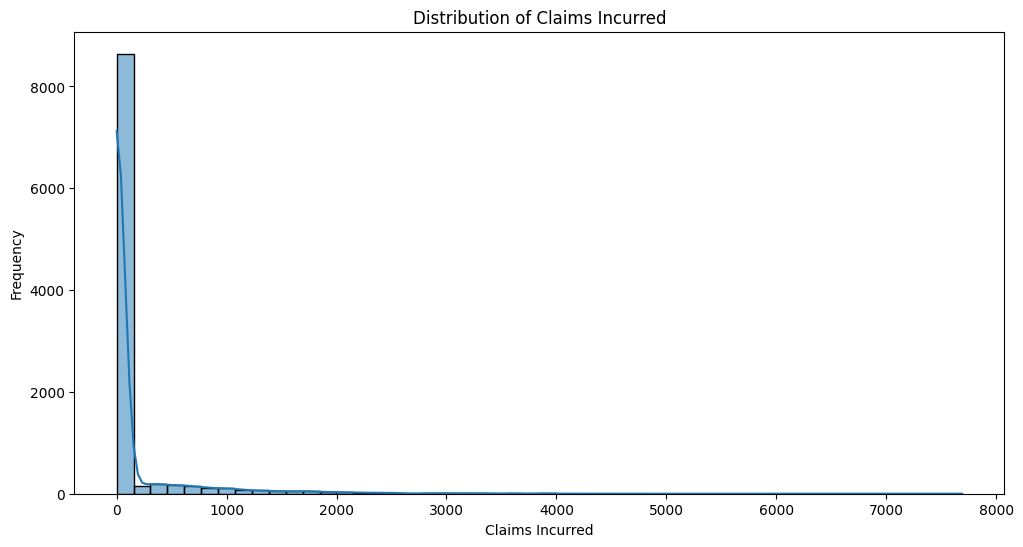

Loss Ratio by Pet Breed:
           claims_incurred  annual_premium  loss_ratio
pet_breed                                             
Beagle       137902.014046   772181.360936    0.178588
Bulldog      535034.187034   939684.315797    0.569377
Labrador     341654.647394   855058.184548    0.399569
Mixed        214418.874065   762987.864362    0.281025
Poodle       179455.812748   805060.543776    0.222910


In [2]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.histplot(df['claims_incurred'], bins=50, kde=True)
plt.title('Distribution of Claims Incurred')
plt.xlabel('Claims Incurred')
plt.ylabel('Frequency')
plt.show()

# Loss ratio by pet breed
loss_ratio_breed = df.groupby('pet_breed').agg({'claims_incurred': 'sum', 'annual_premium': 'sum'})
loss_ratio_breed['loss_ratio'] = loss_ratio_breed['claims_incurred'] / loss_ratio_breed['annual_premium']
print("Loss Ratio by Pet Breed:")
print(loss_ratio_breed)

In [ ]:
# GLM for Pricing
df_glm = pd.get_dummies(df, columns=['pet_breed', 'location', 'coverage_level'], drop_first=True, dtype=int)
df_glm['claim_count'] = df['claims_incurred'].apply(lambda x: 1 if x > 0 else 0)

# Define features for the model
features = ['pet_age', 'pet_breed_Labrador', 'pet_breed_Mixed', 'pet_breed_Poodle', 'location_Suburban', 'location_Urban']
X = sm.add_constant(df_glm[features])

# Frequency model (Poisson GLM)
freq_model = sm.GLM(df_glm['claim_count'], X, family=sm.families.Poisson()).fit()
print("--- GLM Frequency Model Results ---")
print(freq_model.summary())

# Severity model (Gamma GLM)
df_sev = df[df['claims_incurred'] > 0]
df_glm_sev = df_glm.loc[df_sev.index]
X_sev = sm.add_constant(df_glm_sev[features])

sev_model = sm.GLM(df_sev['claims_incurred'], X_sev, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print("--- GLM Severity Model Results ---")
print(sev_model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

## 4. Reserving Analysis
Here, we'll use the chain-ladder method to estimate the ultimate losses and calculate the Incurred But Not Reported (IBNR) reserves. This is a crucial step in ensuring the financial health of the insurer.

In [ ]:
# Create a sample claims dataset for reserving
claims_data = {
    'accident_year': np.random.randint(2018, 2022, 1000),
    'development_lag': np.random.randint(1, 5, 1000),
    'paid_losses': np.random.randint(100, 5000, 1000)
}
claims_df = pd.DataFrame(claims_data)
claims_df['paid_losses'] = claims_df.groupby(['accident_year', 'development_lag'])['paid_losses'].transform('sum')
claims_df = claims_df.drop_duplicates()

# Create loss triangle
loss_triangle = claims_df.pivot(index='accident_year', columns='development_lag', values='paid_losses').fillna(0)
print("--- Loss Development Triangle ---")
print(loss_triangle)

# Chain-Ladder Method
def chain_ladder(triangle):
    triangle = triangle.copy()
    for i in range(triangle.shape[1] - 1):
        col1 = triangle.iloc[:, i]
        col2 = triangle.iloc[:, i+1]
        factor = col2.sum() / col1.sum()
        for j in range(triangle.shape[0] - (i + 1)):
            triangle.iloc[j, i+1] = triangle.iloc[j, i] * factor
    return triangle

projected_triangle = chain_ladder(loss_triangle)
print("--- Projected Loss Triangle (Chain-Ladder) ---")
print(projected_triangle)

# Calculate ultimate losses and IBNR
ultimate_losses = projected_triangle.iloc[:, -1]
paid_to_date = loss_triangle.max(axis=1)
ibnr = ultimate_losses - paid_to_date

reserves = pd.DataFrame({'Ultimate Losses': ultimate_losses, 'Paid to Date': paid_to_date, 'IBNR': ibnr})
print("\n--- Reserve Estimation ---")
print(reserves)
print(f"\nTotal IBNR Reserves: ${reserves['IBNR'].sum():,.2f}")

## 5. Conclusion and Next Steps
This analysis provides a comprehensive actuarial framework for Pawtect Insurance's new pet insurance product. The ratemaking model offers a data-driven approach to pricing, while the reserving analysis ensures the company's solvency.

**Next Steps:**
* Implement the proposed premium structure and monitor its performance.
* Incorporate external data, such as veterinary cost inflation, to enhance the models.
* Develop a more sophisticated reserving model using claim-level data.